In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
arxiv_data = pd.read_csv("arxiv_data.csv")

In [3]:
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [4]:
arxiv_data.shape

(51774, 3)

In [5]:
arxiv_data.isnull().sum()

titles       0
summaries    0
terms        0
dtype: int64

In [6]:
arxiv_data.duplicated().sum()

np.int64(12783)

In [7]:
labels_column = arxiv_data['terms'].apply(literal_eval)
labels = labels_column.explode().unique()
print("labels :",labels)
print("lenght :",len(labels))

labels : ['cs.CV' 'cs.LG' 'cs.AI' ... 'I.2.6; I.5.1; G.3'
 '92E10, 46M20, 94A08, 68U10, 44A12, 55R35' '92E10']
lenght : 1099


In [8]:
arxiv_data = arxiv_data[~arxiv_data['titles'].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")
print(sum(arxiv_data['terms'].value_counts()==1))
print(arxiv_data['terms'].nunique())

There are 38972 rows in the deduplicated dataset.
2321
3157


In [9]:
arxiv_data_filtered = arxiv_data.groupby('terms').filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

In [10]:
arxiv_data_filtered['terms'] = arxiv_data_filtered['terms'].apply(lambda x: literal_eval(x))
arxiv_data_filtered['terms'].values[:3]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI'])], dtype=object)

In [11]:
test_split = 0.1

train_df, test_df = train_test_split(arxiv_data_filtered,test_size=test_split,stratify=arxiv_data_filtered["terms"].values,)

val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


In [12]:
terms = tf.ragged.constant(train_df['terms'].values)
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
lookup.adapt(terms)
vocab = lookup.get_vocabulary()
print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', np.str_('cs.CV'), np.str_('cs.LG'), np.str_('stat.ML'), np.str_('cs.AI'), np.str_('eess.IV'), np.str_('cs.RO'), np.str_('cs.CL'), np.str_('cs.NE'), np.str_('cs.CR'), np.str_('math.OC'), np.str_('eess.SP'), np.str_('cs.GR'), np.str_('cs.SI'), np.str_('cs.MM'), np.str_('cs.SY'), np.str_('cs.IR'), np.str_('cs.MA'), np.str_('eess.SY'), np.str_('cs.HC'), np.str_('math.IT'), np.str_('cs.IT'), np.str_('cs.DC'), np.str_('cs.CY'), np.str_('stat.AP'), np.str_('stat.TH'), np.str_('math.ST'), np.str_('stat.ME'), np.str_('eess.AS'), np.str_('cs.SD'), np.str_('q-bio.QM'), np.str_('q-bio.NC'), np.str_('cs.DS'), np.str_('cs.GT'), np.str_('cs.CG'), np.str_('cs.SE'), np.str_('cs.NI'), np.str_('I.2.6'), np.str_('stat.CO'), np.str_('math.NA'), np.str_('cs.NA'), np.str_('physics.chem-ph'), np.str_('cs.DB'), np.str_('q-bio.BM'), np.str_('cs.PL'), np.str_('cs.LO'), np.str_('cond-mat.dis-nn'), np.str_('68T45'), np.str_('math.PR'), np.str_('physics.comp-ph'), np.str_('cs.CE'), np.str_('c

In [13]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.CV', 'cs.AI', 'cs.LG']
Label-binarized representation: [[0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]]


In [14]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["summaries"].values, label_binarized))
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)
    
"""
In summary, the make_dataset function is designed to create a 
dataset suitable for training a model. It takes a dataframe as input, 
assumes it has "summaries" and "terms" columns, and creates a dataset of 
batches where each batch consists of abstract 
sequences and their corresponding binarized label sequences. 
"""


'\nIn summary, the make_dataset function is designed to create a \ndataset suitable for training a model. It takes a dataframe as input, \nassumes it has "summaries" and "terms" columns, and creates a dataset of \nbatches where each batch consists of abstract \nsequences and their corresponding binarized label sequences. \n'

In [15]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [16]:
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

153497


In [17]:
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size,ngrams=2,output_mode="tf_idf")
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [18]:
train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

model1 = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),  
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),  
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)

history = model1.fit(train_dataset,validation_data=validation_dataset,epochs=20,callbacks=[early_stopping])

Epoch 1/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 162s 598ms/step - binary_accuracy: 0.9445 - loss: 0.1305 - val_binary_accuracy: 0.9944 - val_loss: 0.0194
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 152s 586ms/step - binary_accuracy: 0.9942 - loss: 0.0207 - val_binary_accuracy: 0.9945 - val_loss: 0.0189
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 150s 580ms/step - binary_accuracy: 0.9954 - loss: 0.0154 - val_binary_accuracy: 0.9944 - val_loss: 0.0196
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 192s 742ms/step - binary_accuracy: 0.9962 - loss: 0.0126 - val_binary_accuracy: 0.9944 - val_loss: 0.0198
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 161s 625ms/step - binary_accuracy: 0.9968 - loss: 0.0106 - val_binary_accuracy: 0.9944 - val_loss: 0.0199
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 154s 594ms/step - binary_accuracy: 0.9972 - loss: 0.0094 - val_binary_accuracy: 0.9943 - val_loss: 0.0205
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 152s 589ms/step - binary_accuracy: 0.9975 - loss: 0.0084 - val_binary_accuracy: 0.99

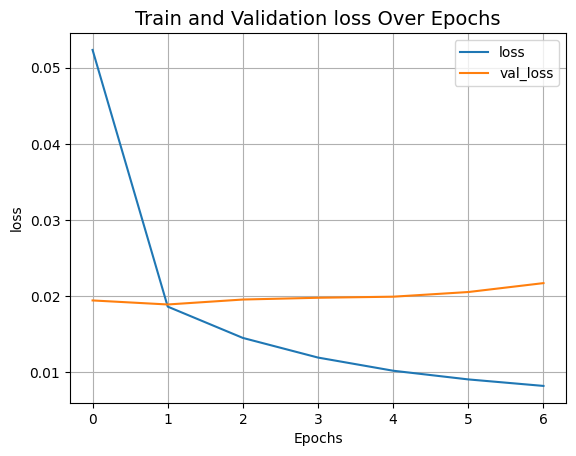

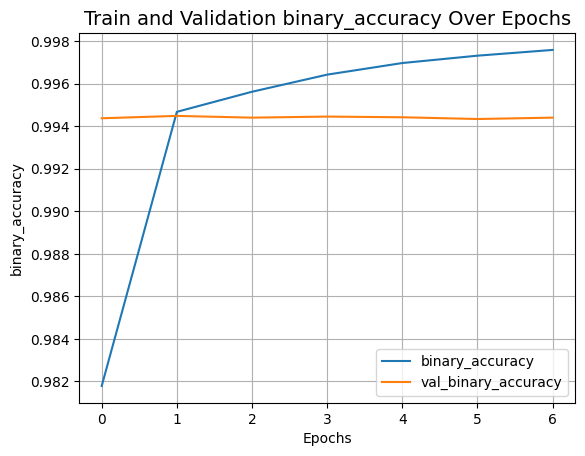

In [20]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [21]:
_, binary_acc1 = model1.evaluate(test_dataset)
_, binary_acc2 = model1.evaluate(validation_dataset)

print(f"Categorical accuracy on the test set: {round(binary_acc1 * 100, 2)}%.")
print(f"Categorical accuracy on the validation set: {round(binary_acc2 * 100, 2)}%.")

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - binary_accuracy: 0.9944 - loss: 0.0190 
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - binary_accuracy: 0.9945 - loss: 0.0186
Categorical accuracy on the test set: 99.43%.
Categorical accuracy on the validation set: 99.45%.


In [23]:
import pickle
model1.save("models/model.h5")

saved_text_vectorizer_config = text_vectorizer.get_config()
with open("models/text_vectorizer_config.pkl", "wb") as f:
    pickle.dump(saved_text_vectorizer_config, f)

vocab = text_vectorizer.get_vocabulary()
with open("models/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

saved_text_vectorizer_weights = text_vectorizer.get_weights()
with open("models/text_vectorizer_weights.pkl", "wb") as f:
    pickle.dump(saved_text_vectorizer_weights, f)


In [24]:
from tensorflow import keras
import pickle

loaded_model = keras.models.load_model("models/model.h5")

from tensorflow.keras.layers import TextVectorization

with open("models/text_vectorizer_config.pkl", "rb") as f:
    saved_text_vectorizer_config = pickle.load(f)

loaded_text_vectorizer = TextVectorization.from_config(saved_text_vectorizer_config)

with open("models/text_vectorizer_weights.pkl", "rb") as f:
    weights = pickle.load(f)
    loaded_text_vectorizer.set_weights(weights)

In [25]:
with open("models/vocab.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)

In [26]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(loaded_vocab, hot_indices)

In [27]:
def predict_category(summaries, model, vectorizer, label_lookup):
    preprocessed_summaries = vectorizer([summaries])
    predictions = model.predict(preprocessed_summaries)
    predicted_labels = label_lookup(np.round(predictions).astype(int)[0])

    return predicted_labels

In [28]:
arxiv_data['titles'][2]

'Enforcing Mutual Consistency of Hard Regions for Semi-supervised Medical Image Segmentation'

In [29]:
arxiv_data['summaries'][1]

"The recent advancements in artificial intelligence (AI) combined with the\nextensive amount of data generated by today's clinical systems, has led to the\ndevelopment of imaging AI solutions across the whole value chain of medical\nimaging, including image reconstruction, medical image segmentation,\nimage-based diagnosis and treatment planning. Notwithstanding the successes and\nfuture potential of AI in medical imaging, many stakeholders are concerned of\nthe potential risks and ethical implications of imaging AI solutions, which are\nperceived as complex, opaque, and difficult to comprehend, utilise, and trust\nin critical clinical applications. Despite these concerns and risks, there are\ncurrently no concrete guidelines and best practices for guiding future AI\ndevelopments in medical imaging towards increased trust, safety and adoption.\nTo bridge this gap, this paper introduces a careful selection of guiding\nprinciples drawn from the accumulated experiences, consensus, and bes

In [30]:
arxiv_data.drop(columns = ["terms","summaries"], inplace = True)

In [31]:
arxiv_data

,titles
0,Survey on Semantic Stereo Matching / Semantic ...
1,FUTURE-AI: Guiding Principles and Consensus Re...
2,Enforcing Mutual Consistency of Hard Regions f...
3,Parameter Decoupling Strategy for Semi-supervi...
4,Background-Foreground Segmentation for Interio...
...,...
51767,A Ray-based Approach for Boundary Estimation o...
51768,Statistical Denoising for single molecule fluo...
51770,Blinking Molecule Tracking
51771,Towards a Mathematical Foundation of Immunolog...


In [33]:
from sentence_transformers import SentenceTransformer, util 

C:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [35]:
sentences = arxiv_data['titles']

In [36]:
sentences = sentences.dropna().astype(str)

In [37]:
sentences_list = sentences.tolist()

In [38]:
embeddings = model.encode(sentences_list)

In [39]:
embeddings.shape

(38972, 384)

In [40]:
c = 0

for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding length:", len(embedding)) 
    print("")
    
    if c >=5:
        break
    c +=1 

Sentence: Survey on Semantic Stereo Matching / Semantic Depth Estimation
Embedding length: 384

Sentence: FUTURE-AI: Guiding Principles and Consensus Recommendations for Trustworthy Artificial Intelligence in Future Medical Imaging
Embedding length: 384

Sentence: Enforcing Mutual Consistency of Hard Regions for Semi-supervised Medical Image Segmentation
Embedding length: 384

Sentence: Parameter Decoupling Strategy for Semi-supervised 3D Left Atrium Segmentation
Embedding length: 384

Sentence: Background-Foreground Segmentation for Interior Sensing in Automotive Industry
Embedding length: 384

Sentence: EdgeFlow: Achieving Practical Interactive Segmentation with Edge-Guided Flow
Embedding length: 384



In [41]:
import pickle

with open('models/embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

with open('models/sentences.pkl', 'wb') as f:
    pickle.dump(sentences, f)
    
with open('models/rec_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [42]:
embeddings = pickle.load(open('models/embeddings.pkl','rb'))
sentences = pickle.load(open('models/sentences.pkl','rb'))
rec_model = pickle.load(open('models/rec_model.pkl','rb'))

In [43]:
import torch

def recommendation(input_paper):
    
    cosine_scores = util.cos_sim(embeddings, rec_model.encode(input_paper))
    
    top_similar_papers = torch.topk(cosine_scores, dim=0, k=5, sorted=True)
                                 
    papers_list = []
    for i in top_similar_papers.indices:
        papers_list.append(sentences[i.item()])
    
    return papers_list

In [44]:
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)

print("We recommend to read this paper............")
print("=============================================")
for paper in recommend_papers:
    print(paper)

Enter the title of any paper you like Blinking Molecule Tracking


We recommend to read this paper............
Split and Connect: A Universal Tracklet Booster for Multi-Object Tracking
Progressive Learning and Disentanglement of Hierarchical Representations
Test-Cost Sensitive Methods for Identifying Nearby Points
TempoRL: Learning When to Act
Learning Inductive Attention Guidance for Partially Supervised Pancreatic Ductal Adenocarcinoma Prediction


In [45]:
import sentence_transformers
import tensorflow
import torch
print(torch.__version__)
print(sentence_transformers.__version__)
print(tensorflow.__version__)

2.5.1+cpu
3.3.1
2.18.0
